In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from lib.NaiveBayesClassifier import NaiveBayesClassifier
from sklearn.feature_selection import mutual_info_regression
from lib.Classifier import Classifier
from sklearn.preprocessing import MinMaxScaler
from functools import cache
from scipy import signal
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# pip install scikeras[tensorflow]

In [3]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

def butter_bandpass(lowcut,highcut,fs,order):
    nyq=0.5*fs
    low=lowcut/nyq
    high=highcut/nyq
    b,a = signal.butter(8,[low,high],'bandpass')
    return b,a
def butter_bandpass_filter(data,lowcut,highcut,fs,order):
    b,a=butter_bandpass(lowcut,highcut,fs,order)
    y=signal.filtfilt(b,a,data,axis=2)
    return y


@cache
def transform_FBCSP(array_name:str,csps_list_name:str,freq=[4,8,12,16,20,24,28,32,36,40]):
    array = globals()[array_name]
    csps = globals()[csps_list_name]
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

@cache
def transform_FBCSP_channel(array_name:str,csps_list_name:str,pca,freq=[4,8,12,16,20,24,28,32,36,40]):
    csps = globals()[csps_list_name]
    array = transform_channel_per_event(array_name,pca)
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [4]:
metrics = []
subjects_range = range(1, 10)
for subject in subjects_range:
    fileName = f'../../datasources/BCICIV_2a_gdf/A{subject:02d}T.gdf'

    if subject == subjects_range[0]:
        raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)
    else:
        new_raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)
        raw = mne.io.concatenate_raws([raw, new_raw])
            


c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Cha

In [5]:
raw_backup = raw.copy()

In [6]:
raw = raw_backup.copy()

In [7]:
names = {'EEG-Fz':'Fz',
 'EEG-0':'FC3',
 'EEG-1':'FC1',
 'EEG-2':'FCz',
 'EEG-3':'FC2',
 'EEG-4':'FC4',
 'EEG-5':'C5',
 'EEG-C3':'C3',
 'EEG-6':'C1',
 'EEG-Cz':'Cz',
 'EEG-7':'C2',
 'EEG-C4':'C4',
 'EEG-8':'C6',
 'EEG-9':'CP3',
 'EEG-10':'CP1',
 'EEG-11':'CPz',
 'EEG-12':'CP2',
 'EEG-13':'CP4',
 'EEG-14':'P1',
 'EEG-Pz':'Pz',
 'EEG-15':'P2',
 'EEG-16':'POz',
 'EOG-left':'EOG-left',
 'EOG-central':'EOG-central',
 'EOG-right':'EOG-right'}
raw.rename_channels(names)
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})

# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage,on_missing ='warn')

raw.set_channel_types({'EOG-LEFT':'eog',
 'EOG-CENTRAL':'eog',
 'EOG-RIGHT':'eog'})

raw.annotations.rename({'769':"left", '770':"right"})

events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(4.0, 40.0, fir_design="firwin", skip_by_annotation="edge")


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '771', '772', 'left', 'right']
Filtering raw data in 9 contiguous segments


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\1342731742.py:33: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The channels missing from the montage are:

['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage,on_missing ='warn')


Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.4s finished


<RawGDF | A01T.gdf, 25 x 6005911 (24023.6 s), ~1.12 GB, data loaded>

In [8]:
# raw.load_data()
# raw.set_eeg_reference("average")
# eog_epochs = mne.preprocessing.create_eog_epochs(raw, l_freq=5.0, h_freq=42)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average("all")

# model_evoked = mne.preprocessing.EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
# raw_clean = model_evoked.apply(raw)

raw_clean = raw


In [9]:
raw_clean.drop_channels(['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'])
picks = mne.pick_types(raw_clean.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
tmin, tmax = -1.0, 4.0


epochs = mne.Epochs(
    raw_clean,
    event_id=[7, 8],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Not setting metadata
1296 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1296 events and 1251 original time points ...
0 bad epochs dropped


In [10]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.

# The fixation cue start seems to be the event start, which takes 1,25 seconds. Removing 2 seconds from start for task assimilation. The event takes 6s +- 1s, to avoid adaptation, but the BCI only takes 3s.

epochs_train = epochs.copy().crop(tmin=2.0, tmax=4.0)
# epochs_train = epochs.copy().crop(tmin=0.5, tmax=2.5)

labels = epochs.events[:, -1] - 7

In [11]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


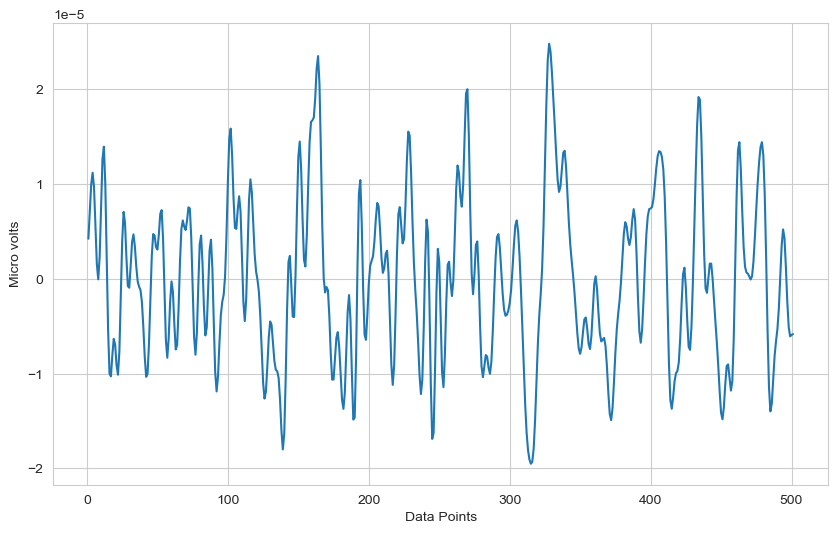

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(epochs_data_train[0][0])+1))
ax.plot(eixo_x, epochs_data_train[0][0])
ax.set_xlabel("Data Points")
ax.set_ylabel("Micro volts")
plt.show()

In [13]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(1296, 22, 501)

In [14]:
list_array = []
for epoch in epochs_data_train:
    list_array.append((epoch - np.min(epoch))/(np.max(epoch)-np.min(epoch)))
epochs_data_train_normalized = np.array(list_array)

In [15]:
epochs_data_train_normalized.shape

(1296, 22, 501)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(epochs_data_train_normalized, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [17]:
concat_X_train = concat_channels("X_train")

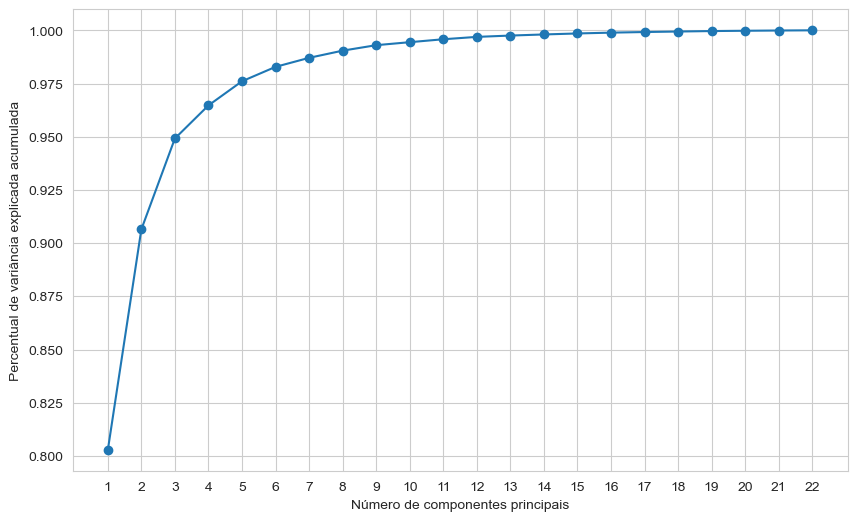

[0.802625 0.906417 0.949168 0.964707 0.976053 0.982825 0.987067 0.990442
 0.993014 0.994422 0.995799 0.996913 0.997535 0.998055 0.998524 0.998906
 0.999196 0.999431 0.99965  0.999791 0.999911 1.      ] 0.9904421702611106


In [18]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[8-1])

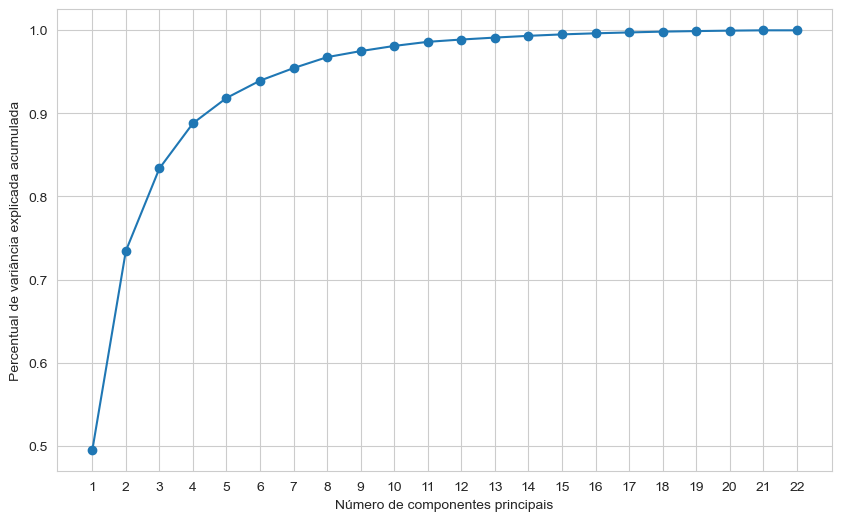

[0.49438  0.734366 0.833716 0.888059 0.918542 0.939401 0.954533 0.967721
 0.974983 0.98121  0.986137 0.988911 0.991252 0.993362 0.995094 0.996392
 0.997459 0.998433 0.999071 0.999604 1.       1.      ] 0.9749830854557767


In [19]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[9-1])

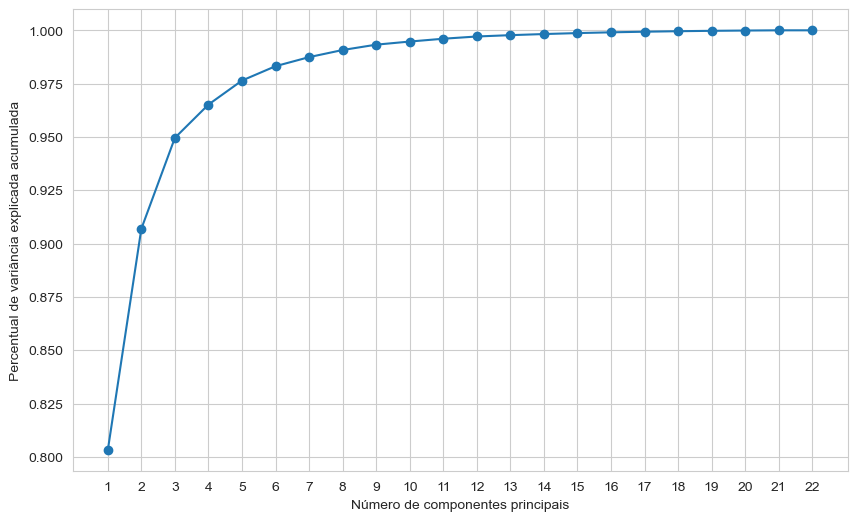

[0.80311  0.906943 0.949592 0.965185 0.97645  0.983185 0.987431 0.990767
 0.993275 0.994735 0.996057 0.997105 0.997727 0.99825  0.998701 0.999062
 0.999343 0.999581 0.999761 0.999897 1.       1.      ] 0.9907671791562088


In [20]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[8-1])

In [21]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

PCA(random_state=42)

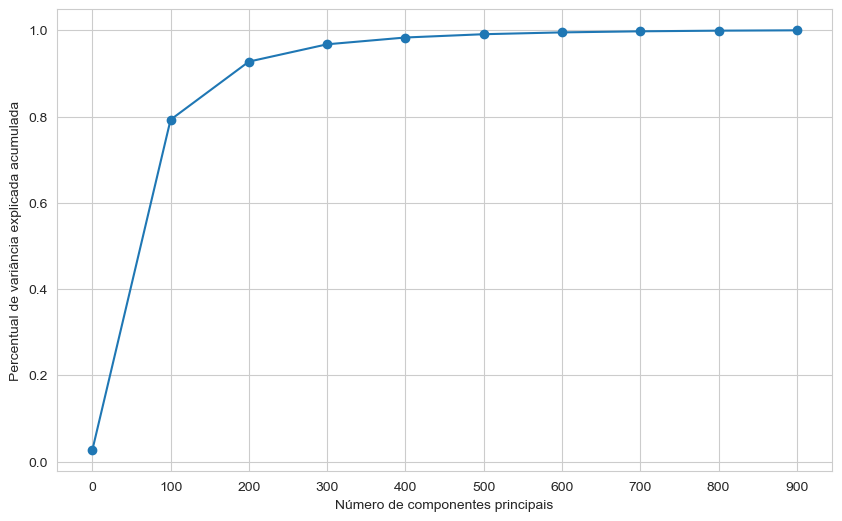

0.9832079970186648


In [22]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Percentual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all[400-1])

In [23]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


In [24]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

In [25]:
num_pca_all = 400


In [26]:
# pca900_all = PCA(random_state=42,n_components=num_pca_all)
# pca900_all.fit(concat_X_train)

In [27]:
num_csp4 = 3
num_csp15 = 4
num_pca_data = 10
num_pca_channel = 15


In [28]:
pca12_channel = PCA(random_state=42,n_components=num_pca_channel)
for event in X_train:
    pca12_channel.fit(event.T)

In [29]:
pca16_data = PCA(random_state=42,n_components=num_pca_data)
for event in X_train:
    pca16_data.fit(event)

In [30]:
csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 7.7e-05 (2.2e-16 eps * 22 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-05 (2.2e-16 eps * 22 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [31]:

csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 7.7e-05 (2.2e-16 eps * 22 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-05 (2.2e-16 eps * 22 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [32]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

features_train=[]
features_test=[]
pca12_channel_fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(transform_list.T,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    pca12_channel_fbcsps.append(csp)


Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 15 dim * 9.3e+09  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 15 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 15 dim * 5.2e+09  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 15 dim * 5.2e+09  max singular value)


In [33]:
features_train=[]
features_test=[]
fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(X_train,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    fbcsps.append(csp)

Computing rank from data with rank=None
    Using tolerance 4.5e-05 (2.2e-16 eps * 22 dim * 9.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-05 (2.2e-16 eps * 22 dim * 5.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-05 (2.2e-16 eps * 22 dim * 5.2e+09  max singular value)


In [34]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps * 15 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.3e-05 (2.2e-16 eps * 15 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [35]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps * 15 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.3e-05 (2.2e-16 eps * 15 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 15
    MAG: rank 15 computed from 15 data channels with 0 projectors
Reducing data rank from 15 -> 15
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [36]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=num_csp4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 4.6e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [37]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=num_csp15, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 4.6e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [38]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [39]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

In [40]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

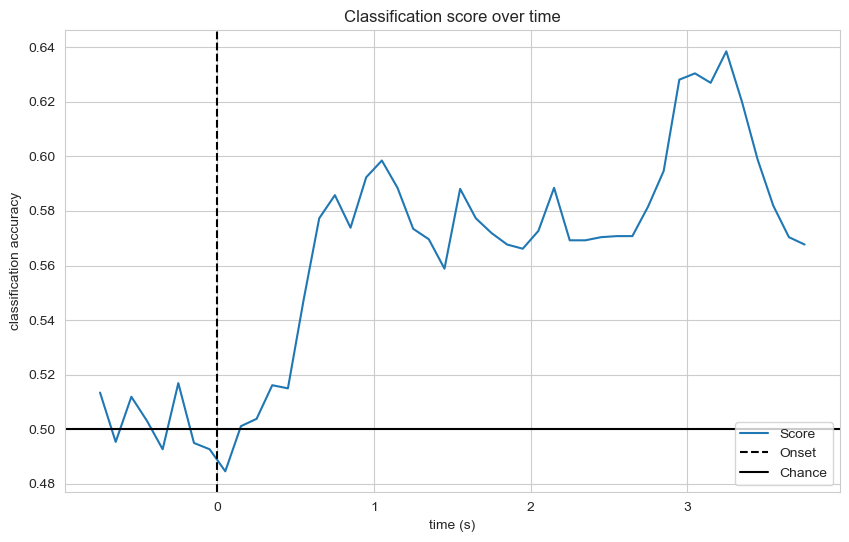

In [41]:
epochs_data_local = epochs.get_data()
epochs_data_train_local = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train_local)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_local.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]

    X_train_local = csp4.transform(epochs_data_train_local[train_idx])

    # fit classifier
    lda.fit(X_train_local, y_train_local)

cv_split = cv.split(epochs_data_train_local)

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test_local = csp4.transform(epochs_data_local[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test_local, y_test_local))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [42]:
# variancia_explicada_acumulada_channel = np.cumsum(ff.explained_variance_ratio_)


# fig, ax = plt.subplots(figsize=(10, 6))
# eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
# ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
# ax.set_xlabel("Número de componentes principais")
# ax.set_ylabel("Percentual de variância explicada acumulada")
# ax.set_xticks(eixo_x)
# plt.show()
# print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[10-1])

In [43]:
import numpy as np

class Classifier:
    def __init__(self,model,FeatureSelectModel=None):
        self.model = model
        self.feature_selection = False
        self.FeatureSelectModel = FeatureSelectModel

    def predict(self,x_features):
        if self.feature_selection:
            x_features_selected = self.feature_selection.transform(x_features)
        else:
            x_features_selected = x_features
        y_predicted = self.model.predict(x_features_selected)
        return y_predicted

    def fit(self,x_features,y_train):
        feature_selection = True
        if feature_selection:
            if self.FeatureSelectModel is None:
                self.feature_selection = FeatureSelect()
            else:
                self.feature_selection = self.FeatureSelectModel
            
            x_train_features_selected = self.feature_selection.fit_transform(x_features,y_train)
        else:
            x_train_features_selected = x_features
        self.model.fit(x_train_features_selected,y_train)
        y_predicted = self.model.predict(x_train_features_selected)
        return y_predicted
    
    def score(self, x_test, y_test):
        y_predicted = self.predict(x_test)
        return accuracy_score(y_test, y_predicted)

class FeatureSelect:
    def __init__(self, n_features_select=4, n_csp_pairs=2):
        self.n_features_select = n_features_select
        self.n_csp_pairs = n_csp_pairs
        self.features_selected_indices=[]

    def fit_transform(self,x_train_features,y_train):
        MI_features = self.MIBIF(x_train_features, y_train)
        MI_sorted_idx = np.argsort(MI_features)[::-1]
        features_selected = MI_sorted_idx[:self.n_features_select]

        paired_features_idx = self.select_CSP_pairs(features_selected, self.n_csp_pairs)
        x_train_features_selected = x_train_features[:, paired_features_idx]
        self.features_selected_indices = paired_features_idx

        return x_train_features_selected

    def transform(self,x_test_features):
        return x_test_features[:,self.features_selected_indices]

    def MIBIF(self, x_features, y_labels):
        def get_prob_pw(x,d,i,h):
            n_data = d.shape[0]
            t=d[:,i]
            kernel = lambda u: np.exp(-0.5*(u**2))/np.sqrt(2*np.pi)
            prob_x = 1 / (n_data * h) * sum(kernel((np.ones((len(t)))*x- t)/h))
            return prob_x

        def get_pd_pw(d, i, x_trials):
            n_data, n_dimensions = d.shape
            if n_dimensions==1:
                i=1
            t = d[:,i]
            min_x = np.min(t)
            max_x = np.max(t)
            n_trials = x_trials.shape[0]
            std_t = np.std(t)
            if std_t==0:
                h=0.005
            else:
                h=(4./(3*n_data))**(0.2)*std_t
            prob_x = np.zeros((n_trials))
            for j in range(n_trials):
                prob_x[j] = get_prob_pw(x_trials[j],d,i,h)
            return prob_x, x_trials, h

        y_classes = np.unique(y_labels)
        n_classes = len(y_classes)
        n_trials = len(y_labels)
        prob_w = []
        x_cls = {}
        for i in range(n_classes):
            cls = y_classes[i]
            cls_indx = np.where(y_labels == cls)[0]
            prob_w.append(len(cls_indx) / n_trials)
            x_cls.update({i: x_features[cls_indx, :]})

        prob_x_w = np.zeros((n_classes, n_trials, x_features.shape[1]))
        prob_w_x = np.zeros((n_classes, n_trials, x_features.shape[1]))
        h_w_x = np.zeros((x_features.shape[1]))
        mutual_info = np.zeros((x_features.shape[1]))
        parz_win_width = 1.0 / np.log2(n_trials)
        h_w = -np.sum(prob_w * np.log2(prob_w))

        for i in range(x_features.shape[1]):
            h_w_x[i] = 0
            for j in range(n_classes):
                prob_x_w[j, :, i] = get_pd_pw(x_cls.get(j), i, x_features[:, i])[0]

        t_s = prob_x_w.shape
        n_prob_w_x = np.zeros((n_classes, t_s[1], t_s[2]))
        for i in range(n_classes):
            n_prob_w_x[i, :, :] = prob_x_w[i] * prob_w[i]
        prob_x = np.sum(n_prob_w_x, axis=0)
        # prob_w_x = np.zeros((n_classes, prob_x.shape[0], prob_w.shape[1]))
        for i in range(n_classes):
            prob_w_x[i, :, :] = n_prob_w_x[i, :, :]/prob_x

        for i in range(x_features.shape[1]):
            for j in range(n_trials):
                t_sum = 0.0
                for k in range(n_classes):
                    if prob_w_x[k, j, i] > 0:
                        t_sum += (prob_w_x[k, j, i] * np.log2(prob_w_x[k, j, i]))

                h_w_x[i] -= (t_sum / n_trials)

            mutual_info[i] = h_w - h_w_x[i]

        mifsg = np.asarray(mutual_info)
        return mifsg


    def select_CSP_pairs(self,features_selected,n_pairs):
        features_selected+=1
        sel_groups = np.unique(np.ceil(features_selected/n_pairs))
        paired_features = []
        for i in range(len(sel_groups)):
            for j in range(n_pairs-1,-1,-1):
                paired_features.append(sel_groups[i]*n_pairs-j)

        paired_features = np.asarray(paired_features,dtype=np.int)-1
        print(paired_features)
        return paired_features
        


In [44]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = Pipe("lda_fbcsp",Classifier(LinearDiscriminantAnalysis()),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))

pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 10 11 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 2  3  4  5 14 15 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  2  3  4  5 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  2  3  4  5 16 17]
[ 0  1  2  3  4  5 16 17]
Results for pipeline with lda_fbcsp:
----------------
Test accuracy scores: [0.67033  0.692308 0.67033  0.637363 0.593407 0.681319 0.659341 0.577778
 0.677778 0.588889]
Mean test accuracy: 0.6448840048840048
-----
Test F1 scores: [0.668367 0.691973 0.627049 0.636661 0.536034 0.679927 0.657853 0.563998
 0.674523 0.582654]
Mean test F1: 0.631904014799703
----------------
train accuracy scores: [0.66299  0.678922 0.675245 0.660539 0.699755 0.671569 0.677696 0.678091
 0.681763 0.705018]
Mean train accuracy: 0.6791587167302662
-----
train F1 scores: [0.662438 0.678765 0.675206 0.660392 0.699321 0.671371 0.677521 0.677656
 0.681177 0.704507]
Mean train F1: 0.6788354162417656
----------------
Fit time: [1.524227 1.553855 1.512761 1.503008 1.507467 1.51392  1.503033 1.510239
 1.506988 1.505255]
Score time: [0.       0.       0.002605 0.001696 0.006624 0.001999 0.001999 0.001975
 0.       0.      ]

--------------------------------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


In [45]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

### Not runned MLP

In [46]:
# MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
        # "layers":[
        #     # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
        #     tf.keras.layers.Dense(20, activation='sigmoid'),
        #     tf.keras.layers.Dropout(0.5,seed= 42),
        #     tf.keras.layers.Dense(20, activation='sigmoid'),
        #     tf.keras.layers.Dropout(0.5,seed= 42),
        #     tf.keras.layers.Dense(10, activation='sigmoid'),
        #     tf.keras.layers.Dense(5, activation='sigmoid'),
        #     tf.keras.layers.Dense(3, activation='softmax')
        # ],
        # "optimizer":'adam',
        # "loss": 'sparse_categorical_crossentropy',
        # "metrics": ['accuracy']
    # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))



### Runned Models

In [54]:
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_fbcsp = Pipe("lda_fbcsp",LinearDiscriminantAnalysis(),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))
lda_fbcsp_pca12_channel = Pipe("lda_fbcsp_pca12_channel",LinearDiscriminantAnalysis(),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel))



lda_pca12_channel_with_MIBIF = Pipe("lda_pca12_channel_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# lda_csp4_with_MIBIF = Pipe("lda_csp4_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_pca12_channel_csp4_with_MIBIF = Pipe("lda_pca12_channel_csp4_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_csp15_with_MIBIF = Pipe("lda_csp15_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp15_with_MIBIF = Pipe("lda_pca12_channel_csp15_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_fbcsp_with_MIBIF = Pipe("lda_fbcsp_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))
lda_fbcsp_pca12_channel_with_MIBIF = Pipe("lda_fbcsp_pca12_channel_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel))


parzen_window_mnbc_pca12_channel = Pipe("parzen_window_mnbc_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
parzen_window_mnbc_csp4 = Pipe("parzen_window_mnbc_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
parzen_window_mnbc_pca12_channel_csp4 = Pipe("parzen_window_mnbc_pca12_channel_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
parzen_window_mnbc_csp15 = Pipe("parzen_window_mnbc_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
parzen_window_mnbc_pca12_channel_csp15 = Pipe("parzen_window_mnbc_pca12_channel_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
parzen_window_mnbc_fbcsp = Pipe("parzen_window_mnbc_fbcsp",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
parzen_window_mnbc_fbcsp_pca12_channel = Pipe("parzen_window_mnbc_fbcsp_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )

parzen_window_mnbc_pca12_channel_with_MIBIF = Pipe("parzen_window_mnbc_pca12_channel_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
parzen_window_mnbc_csp4_with_MIBIF = Pipe("parzen_window_mnbc_csp4_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
parzen_window_mnbc_pca12_channel_csp4_with_MIBIF = Pipe("parzen_window_mnbc_pca12_channel_csp4_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
parzen_window_mnbc_csp15_with_MIBIF = Pipe("parzen_window_mnbc_csp15_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
parzen_window_mnbc_pca12_channel_csp15_with_MIBIF = Pipe("parzen_window_mnbc_pca12_channel_csp15_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
parzen_window_mnbc_fbcsp_with_MIBIF = Pipe("parzen_window_mnbc_fbcsp_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF = Pipe("parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )



svm_pca12_channel = Pipe("svm_pca12_channel",SVC(C=1,kernel='rbf'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
svm_csp4 = Pipe("svm_csp4",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
svm_pca12_channel_csp4 = Pipe("svm_pca12_channel_csp4",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
svm_csp15 = Pipe("svm_csp15",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
svm_pca12_channel_csp15 = Pipe("svm_pca12_channel_csp15",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
svm_fbcsp = Pipe("svm_fbcsp",SVC(C=1,kernel='rbf'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
svm_fbcsp_pca12_channel = Pipe("svm_fbcsp_pca12_channel",SVC(C=1,kernel='rbf'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )



svm_pca12_channel_with_MIBIF = Pipe("svm_pca12_channel_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
svm_csp4_with_MIBIF = Pipe("svm_csp4_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
svm_pca12_channel_csp4_with_MIBIF = Pipe("svm_pca12_channel_csp4_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
svm_csp15_with_MIBIF = Pipe("svm_csp15_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
svm_pca12_channel_csp15_with_MIBIF = Pipe("svm_pca12_channel_csp15_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
svm_fbcsp_with_MIBIF = Pipe("svm_fbcsp_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
svm_fbcsp_pca12_channel_with_MIBIF = Pipe("svm_fbcsp_pca12_channel_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )


Pipes= [
lda_pca12_channel,
lda_csp4,
lda_pca12_channel_csp4,
lda_csp15,
lda_pca12_channel_csp15,
lda_fbcsp,
lda_fbcsp_pca12_channel,
# lda_pca12_channel_with_MIBIF,
# lda_csp4_with_MIBIF,
# lda_pca12_channel_csp4_with_MIBIF,
# lda_csp15_with_MIBIF,
# lda_pca12_channel_csp15_with_MIBIF,
lda_fbcsp_with_MIBIF,
lda_fbcsp_pca12_channel_with_MIBIF,
parzen_window_mnbc_pca12_channel,
parzen_window_mnbc_csp4,
parzen_window_mnbc_pca12_channel_csp4,
parzen_window_mnbc_csp15,
parzen_window_mnbc_pca12_channel_csp15,
parzen_window_mnbc_fbcsp,
# parzen_window_mnbc_fbcsp_pca12_channel,
# parzen_window_mnbc_pca12_channel_with_MIBIF,
# parzen_window_mnbc_csp4_with_MIBIF,
# parzen_window_mnbc_pca12_channel_csp4_with_MIBIF,
# parzen_window_mnbc_csp15_with_MIBIF,
# parzen_window_mnbc_pca12_channel_csp15_with_MIBIF,
parzen_window_mnbc_fbcsp_with_MIBIF,
parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF,
svm_pca12_channel,
svm_csp4,
svm_pca12_channel_csp4,
svm_csp15,
svm_pca12_channel_csp15,
svm_fbcsp,
svm_fbcsp_pca12_channel,
# svm_pca12_channel_with_MIBIF,
# svm_csp4_with_MIBIF,
# svm_pca12_channel_csp4_with_MIBIF,
# svm_csp15_with_MIBIF,
# svm_pca12_channel_csp15_with_MIBIF,
svm_fbcsp_with_MIBIF,
svm_fbcsp_pca12_channel_with_MIBIF,   
]


In [48]:




# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
# lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
# mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
# mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
# mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
# mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
# mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
# mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
# mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
# mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# parzen_window_mnbc_with_MIBIF_pca16_data = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# parzen_window_mnbc_with_MIBIF_pca16_data_csp4 = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data_csp4",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# parzen_window_mnbc_with_MIBIF_pca16_data_csp15 = Pipe("parzen_window_mnbc_with_MIBIF_pca16_data_csp15",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# parzen_window_mnbc_without_MIBIF_pca16_data = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# parzen_window_mnbc_without_MIBIF_pca16_data_csp4 = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# parzen_window_mnbc_without_MIBIF_pca16_data_csp15 = Pipe("parzen_window_mnbc_without_MIBIF_pca16_data_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# svm_pca16_data_csp4 = Pipe("svm_pca16_data_csp4",SVC(C=1,kernel='rbf'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# svm_pca16_data = Pipe("svm_pca16_data",SVC(C=1,kernel='rbf'),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# svm_pca16_data_csp15 = Pipe("svm_pca16_data_csp15",SVC(C=1,kernel='rbf'),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# svm_pca900_all = Pipe("svm_pca900_all",SVC(C=1,kernel='rbf'),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))





In [49]:
results = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")

    results[pipe.name] = (cv_results)


lda_pca12_channel
Results for pipeline with lda_pca12_channel:
----------------
Test accuracy scores: [0.461538 0.516484 0.56044  0.373626 0.472527 0.527473 0.505495 0.377778
 0.5      0.566667]
Mean test accuracy: 0.48620268620268614
-----
Test F1 scores: [0.461278 0.516425 0.559109 0.373324 0.472464 0.527473 0.501643 0.37747
 0.496957 0.566185]
Mean test F1: 0.4852326692881174
----------------
train accuracy scores: [0.849265 0.857843 0.844363 0.868873 0.833333 0.844363 0.856618 0.821297
 0.843329 0.844553]
Mean train accuracy: 0.8463836789305687
-----
train F1 scores: [0.849246 0.857835 0.844361 0.868849 0.833332 0.844363 0.856616 0.821284
 0.843327 0.84453 ]
Mean train F1: 0.846374313089518
----------------
Fit time: [2.725671 2.696282 2.723724 2.674923 2.617492 2.607328 2.614145 2.652088
 2.655465 2.652723]
Score time: [0.       0.       0.       0.009209 0.       0.006691 0.002701 0.003164
 0.008176 0.      ]

----------------------------------------------------------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[3748 3749 3762 3763 4206 4207 4222 4223]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[2910 2911 4206 4207 5108 5109 5396 5397]


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[3732 3733 3748 3749 7152 7153 7424 7425]


KeyboardInterrupt: 

In [ ]:
for key, value in results.items(): 
    print(value['test_Accuracy'])
    print(",")
for key, value in results.items(): 
    print(np.mean(value['test_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(np.max(value['test_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(value['test_F1'])
    print(",")
for key, value in results.items(): 
    print(value['train_Accuracy'])
    print(",")
for key, value in results.items(): 
    print(np.mean(value['train_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(np.max(value['train_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(value['train_F1'])
    print(",")
for key, value in results.items(): 
    print(value['fit_time'])
    print(",")
for key, value in results.items(): 
    print(value['score_time'])
    print(",")

In [55]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)


lda_pca12_channel
Results for pipeline with lda_pca12_channel:
----------------
Test accuracy scores: 0.4755784061696658
----------------
train accuracy scores: 0.856670341786108

--------------------------------------------------------------------------------------------
lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.6426735218508998
----------------
train accuracy scores: 0.6240352811466373

--------------------------------------------------------------------------------------------
lda_pca12_channel_csp4
Results for pipeline with lda_pca12_channel_csp4:
----------------
Test accuracy scores: 0.6503856041131105
----------------
train accuracy scores: 0.587651598676957

--------------------------------------------------------------------------------------------
lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.6041131105398457
----------------
train accuracy scores: 0.6571113561190739

-----------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]
Results for pipeline with lda_fbcsp_with_MIBIF:
----------------
Test accuracy scores: 0.5732647814910026
----------------
train accuracy scores: 0.6714443219404631

--------------------------------------------------------------------------------------------
lda_fbcsp_pca12_channel_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1
d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))


[0 1 2 3 4 5 6 7]
Results for pipeline with lda_fbcsp_pca12_channel_with_MIBIF:
----------------
Test accuracy scores: 0.5398457583547558
----------------
train accuracy scores: 0.6659316427783903

--------------------------------------------------------------------------------------------
parzen_window_mnbc_pca12_channel
Results for pipeline with parzen_window_mnbc_pca12_channel:
----------------
Test accuracy scores: 0.5012853470437018
----------------
train accuracy scores: 0.4994487320837927

--------------------------------------------------------------------------------------------
parzen_window_mnbc_csp4
Results for pipeline with parzen_window_mnbc_csp4:
----------------
Test accuracy scores: 0.5732647814910026
----------------
train accuracy scores: 0.5689084895259096

--------------------------------------------------------------------------------------------
parzen_window_mnbc_pca12_channel_csp4
Results for pipeline with parzen_window_mnbc_pca12_channel_csp4:
----------------

d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_fbcsp:
----------------
Test accuracy scores: 0.5012853470437018
----------------
train accuracy scores: 0.4994487320837927

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]
Results for pipeline with parzen_window_mnbc_fbcsp_with_MIBIF:
----------------
Test accuracy scores: 0.519280205655527
----------------
train accuracy scores: 0.6405733186328556

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[0 1 2 3 4 5 6 7]
Results for pipeline with parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF:
----------------
Test accuracy scores: 0.5424164524421594
----------------
train accuracy scores: 0.6163175303197354

--------------------------------------------------------------------------------------------
svm_pca12_channel
Results for pipeline with svm_pca12_channel:
----------------
Test accuracy scores: 0.5629820051413882
----------------
train accuracy scores: 0.9316427783902976

--------------------------------------------------------------------------------------------
svm_csp4
Results for pipeline with svm_csp4:
----------------
Test accuracy scores: 0.5989717223650386
----------------
train accuracy scores: 0.6527012127894156

--------------------------------------------------------------------------------------------
svm_pca12_channel_csp4
Results for pipeline with svm_pca12_channel_csp4:
----------------
Test accuracy scores: 0.6246786632390745
----------------
train accuracy s

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 0  1  4  5 14 15 16 17]
Results for pipeline with svm_fbcsp_with_MIBIF:
----------------
Test accuracy scores: 0.5501285347043702
----------------
train accuracy scores: 0.7155457552370452

--------------------------------------------------------------------------------------------
svm_fbcsp_pca12_channel_with_MIBIF
[0 1 2 3 4 5 6 7]
Results for pipeline with svm_fbcsp_pca12_channel_with_MIBIF:
----------------
Test accuracy scores: 0.5449871465295629
----------------
train accuracy scores: 0.75303197353914

--------------------------------------------------------------------------------------------


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24872\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


lda_pca12_channel
              precision    recall  f1-score   support

           0     0.4759    0.4564    0.4660       195
           1     0.4752    0.4948    0.4848       194

    accuracy                         0.4756       389
   macro avg     0.4756    0.4756    0.4754       389
weighted avg     0.4756    0.4756    0.4754       389



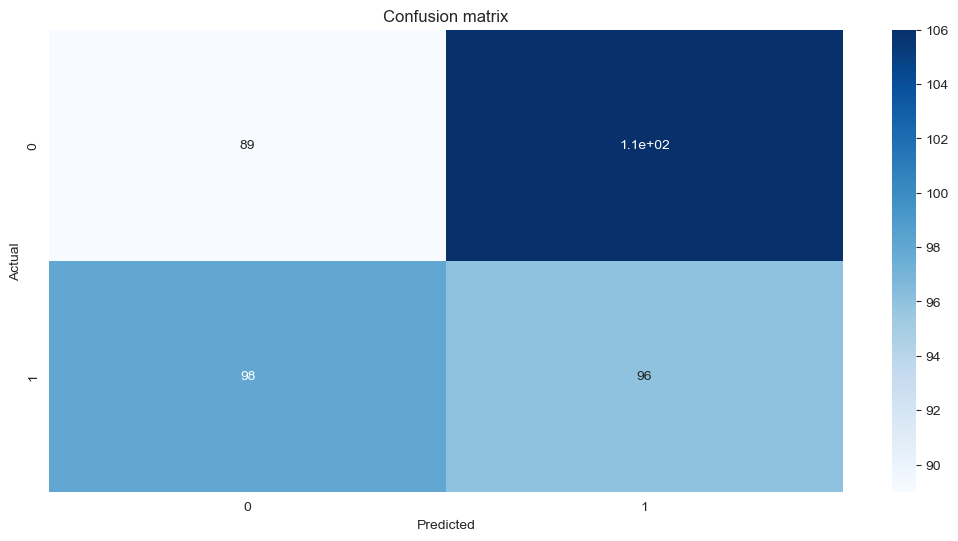

lda_csp4
              precision    recall  f1-score   support

           0     0.7373    0.4462    0.5559       195
           1     0.6015    0.8402    0.7011       194

    accuracy                         0.6427       389
   macro avg     0.6694    0.6432    0.6285       389
weighted avg     0.6696    0.6427    0.6283       389



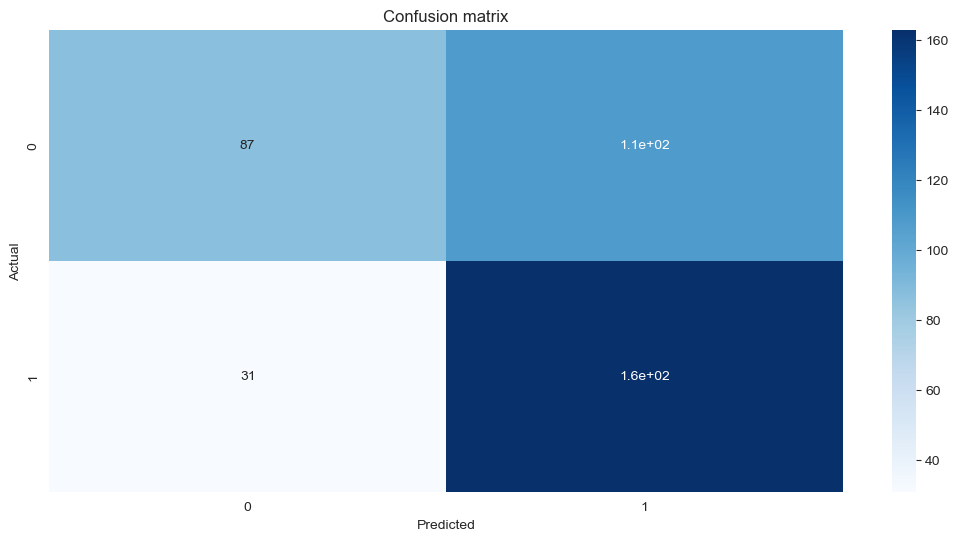

lda_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.7252    0.4872    0.5828       195
           1     0.6124    0.8144    0.6991       194

    accuracy                         0.6504       389
   macro avg     0.6688    0.6508    0.6410       389
weighted avg     0.6689    0.6504    0.6408       389



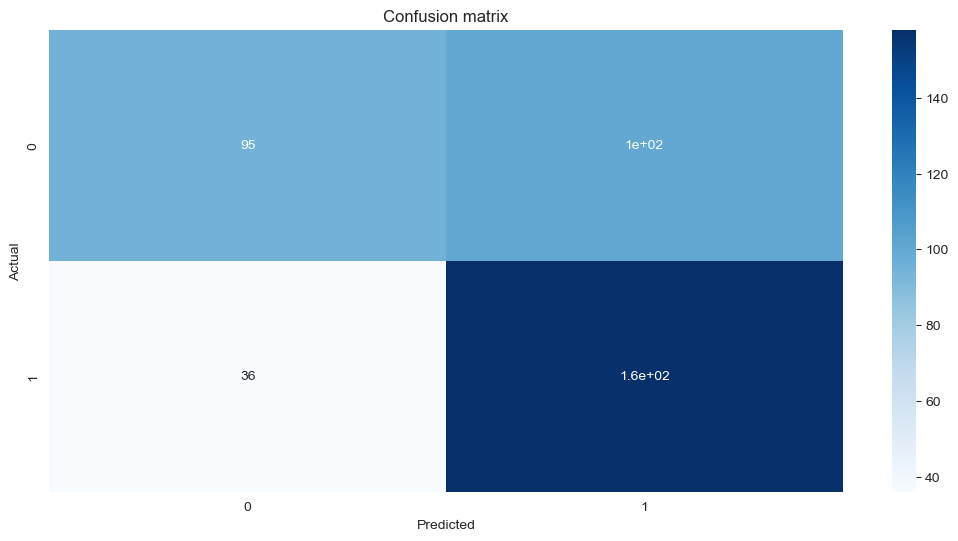

lda_csp15
              precision    recall  f1-score   support

           0     0.7470    0.3179    0.4460       195
           1     0.5654    0.8918    0.6920       194

    accuracy                         0.6041       389
   macro avg     0.6562    0.6049    0.5690       389
weighted avg     0.6564    0.6041    0.5687       389



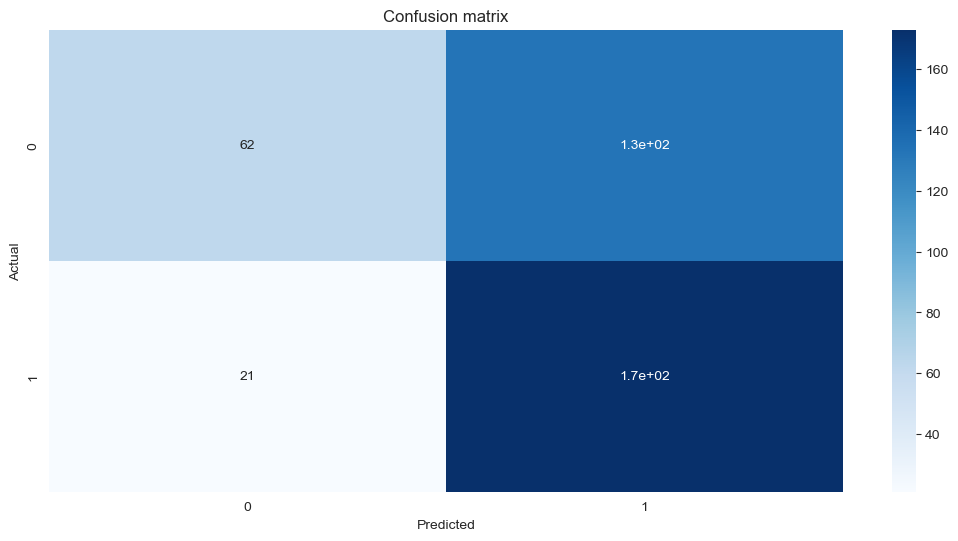

lda_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.6711    0.5231    0.5879       195
           1     0.6076    0.7423    0.6682       194

    accuracy                         0.6324       389
   macro avg     0.6393    0.6327    0.6281       389
weighted avg     0.6394    0.6324    0.6280       389



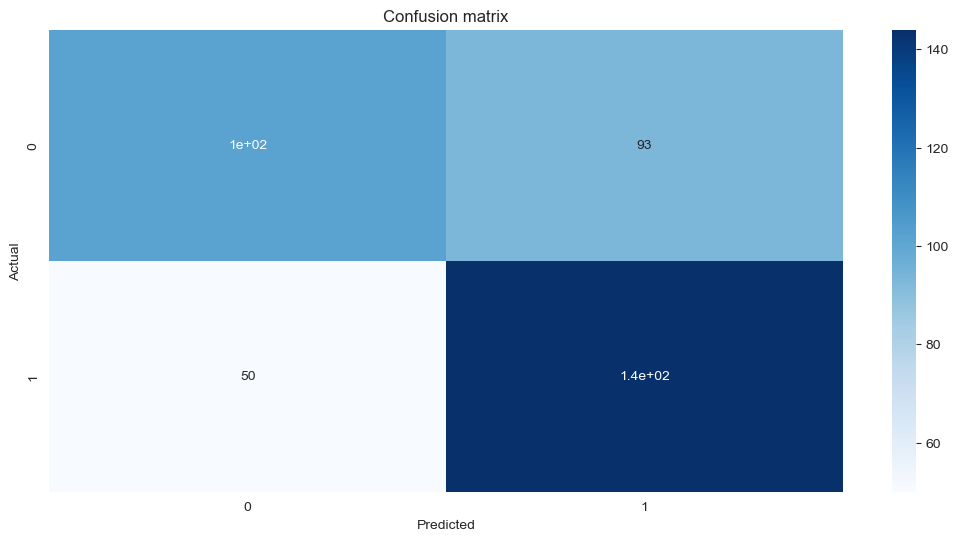

lda_fbcsp
              precision    recall  f1-score   support

           0     0.6020    0.3026    0.4027       195
           1     0.5326    0.7990    0.6392       194

    accuracy                         0.5501       389
   macro avg     0.5673    0.5508    0.5210       389
weighted avg     0.5674    0.5501    0.5206       389



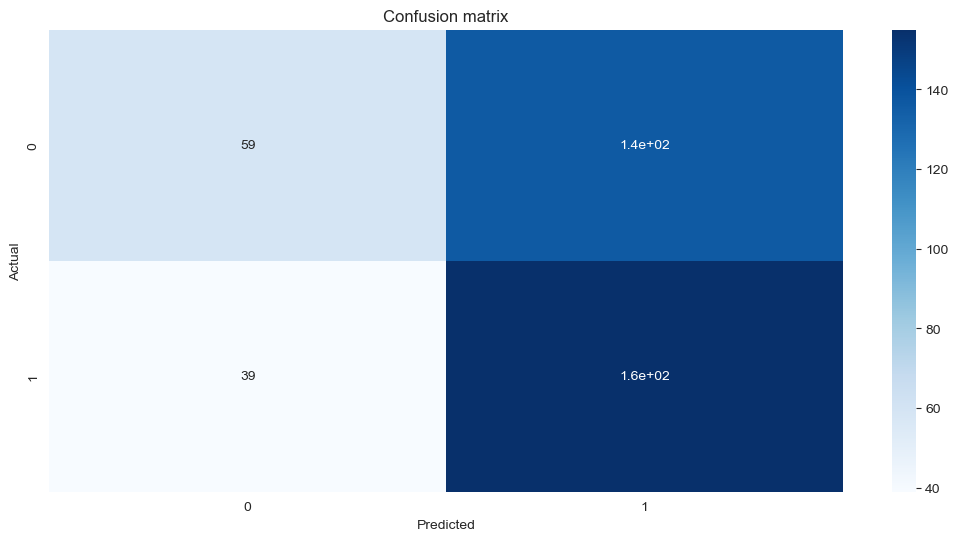

lda_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.6333    0.2923    0.4000       195
           1     0.5385    0.8299    0.6531       194

    accuracy                         0.5604       389
   macro avg     0.5859    0.5611    0.5266       389
weighted avg     0.5860    0.5604    0.5262       389



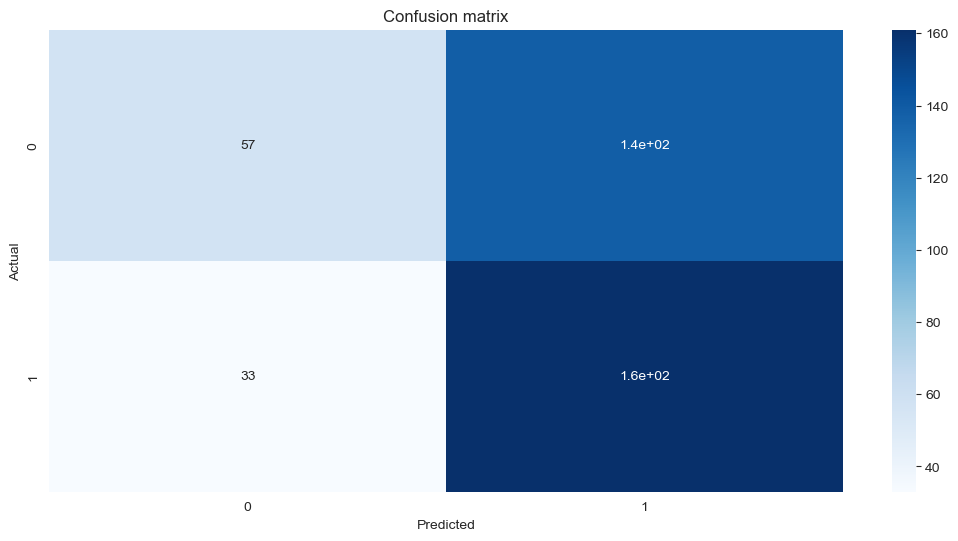

lda_fbcsp_with_MIBIF
              precision    recall  f1-score   support

           0     0.6408    0.3385    0.4430       195
           1     0.5490    0.8093    0.6542       194

    accuracy                         0.5733       389
   macro avg     0.5949    0.5739    0.5486       389
weighted avg     0.5950    0.5733    0.5483       389



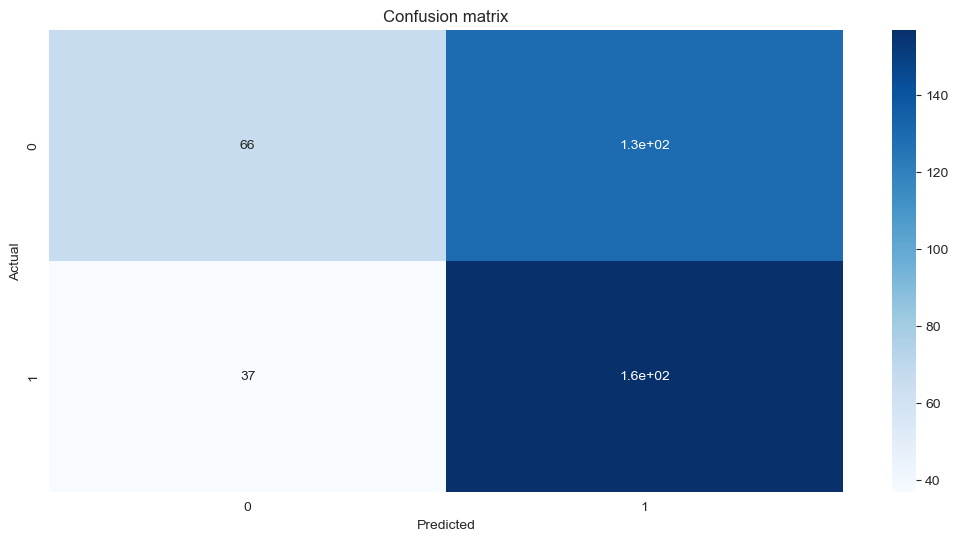

lda_fbcsp_pca12_channel_with_MIBIF
              precision    recall  f1-score   support

           0     0.6250    0.2051    0.3089       195
           1     0.5231    0.8763    0.6551       194

    accuracy                         0.5398       389
   macro avg     0.5740    0.5407    0.4820       389
weighted avg     0.5742    0.5398    0.4815       389



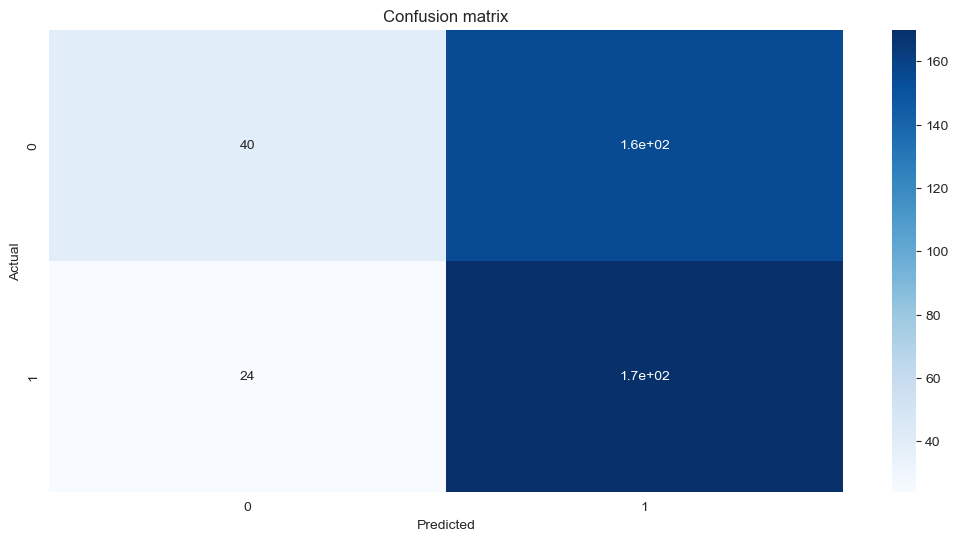

parzen_window_mnbc_pca12_channel


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defin

              precision    recall  f1-score   support

           0     0.5013    1.0000    0.6678       195
           1     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



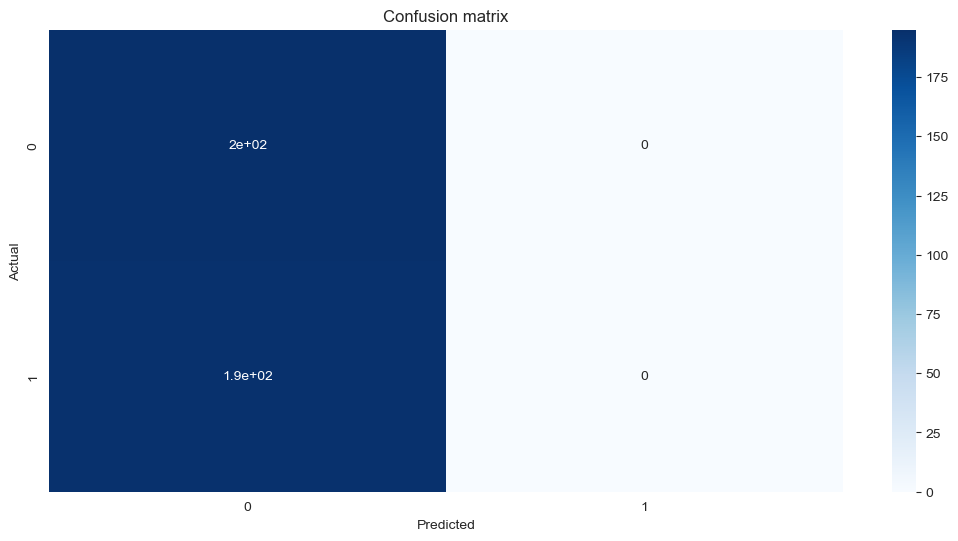

parzen_window_mnbc_csp4
              precision    recall  f1-score   support

           0     0.6559    0.3128    0.4236       195
           1     0.5473    0.8351    0.6612       194

    accuracy                         0.5733       389
   macro avg     0.6016    0.5739    0.5424       389
weighted avg     0.6017    0.5733    0.5421       389



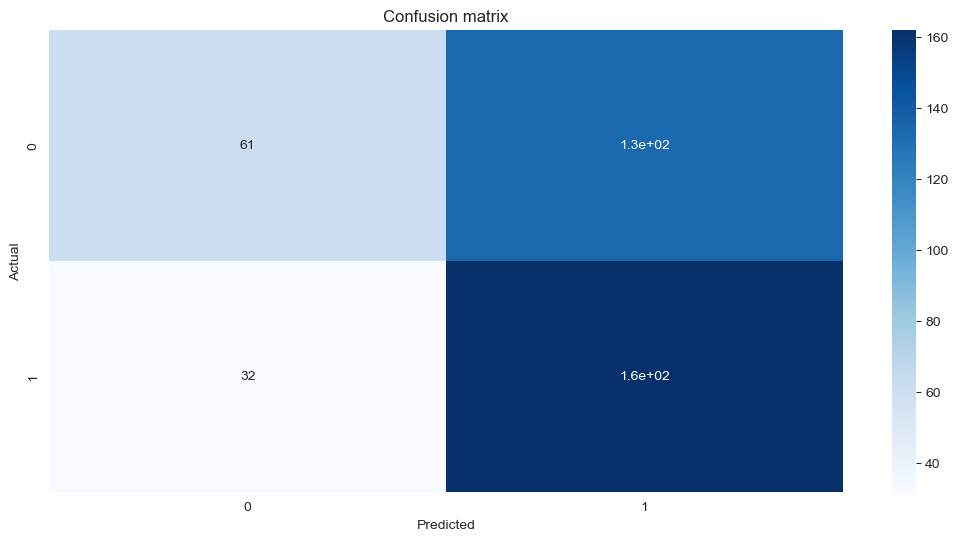

parzen_window_mnbc_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.6863    0.3590    0.4714       195
           1     0.5645    0.8351    0.6736       194

    accuracy                         0.5964       389
   macro avg     0.6254    0.5970    0.5725       389
weighted avg     0.6255    0.5964    0.5722       389



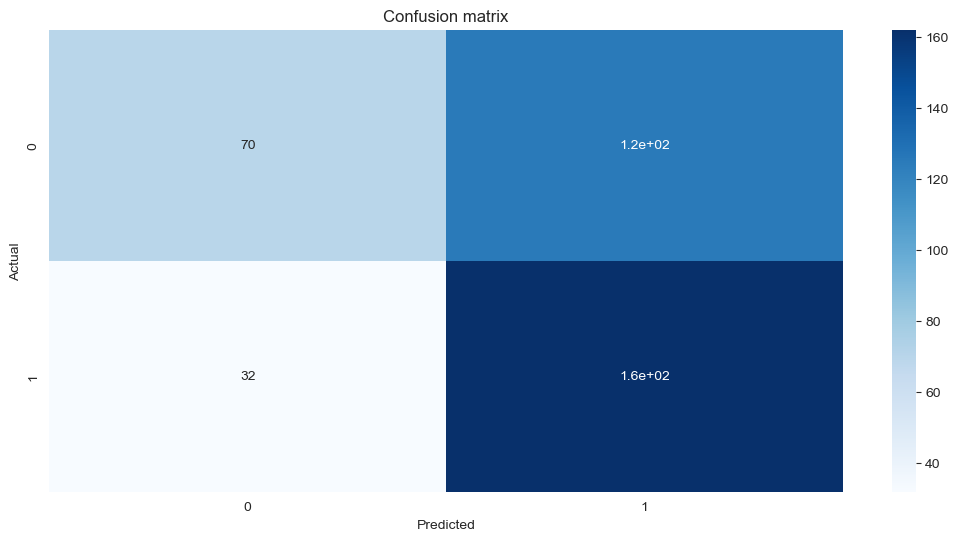

parzen_window_mnbc_csp15
              precision    recall  f1-score   support

           0     0.6515    0.2205    0.3295       195
           1     0.5294    0.8814    0.6615       194

    accuracy                         0.5501       389
   macro avg     0.5905    0.5510    0.4955       389
weighted avg     0.5906    0.5501    0.4951       389



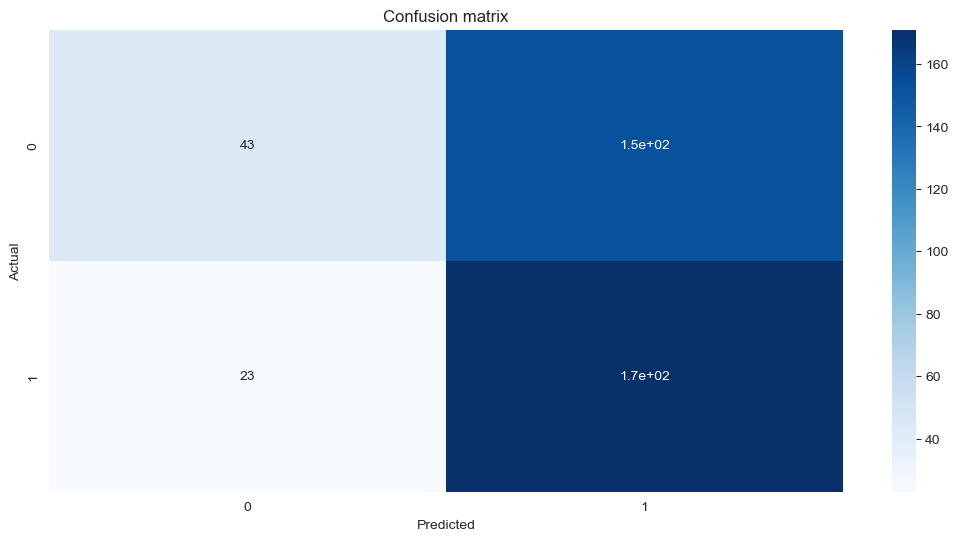

parzen_window_mnbc_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.6742    0.3077    0.4225       195
           1     0.5500    0.8505    0.6680       194

    accuracy                         0.5784       389
   macro avg     0.6121    0.5791    0.5453       389
weighted avg     0.6122    0.5784    0.5450       389



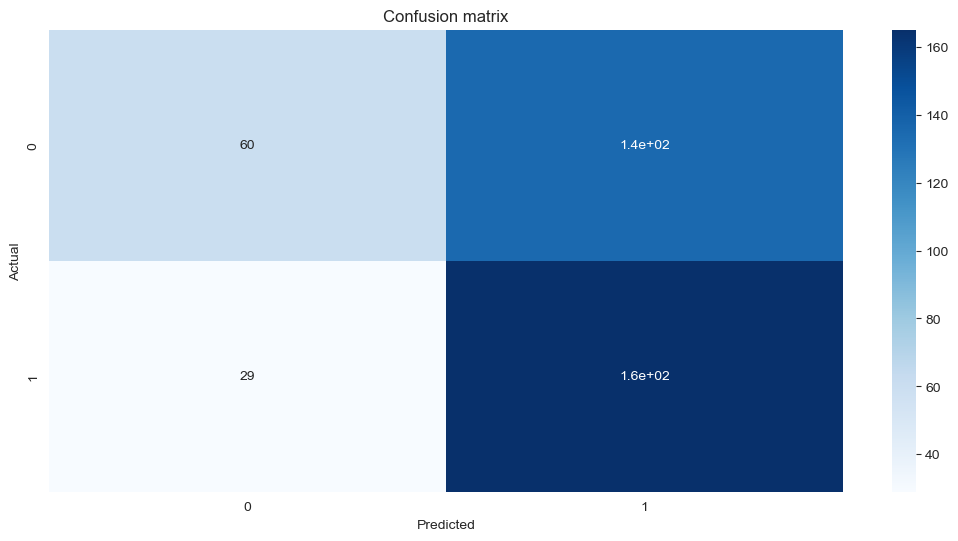

parzen_window_mnbc_fbcsp
              precision    recall  f1-score   support

           0     0.5013    1.0000    0.6678       195
           1     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defi

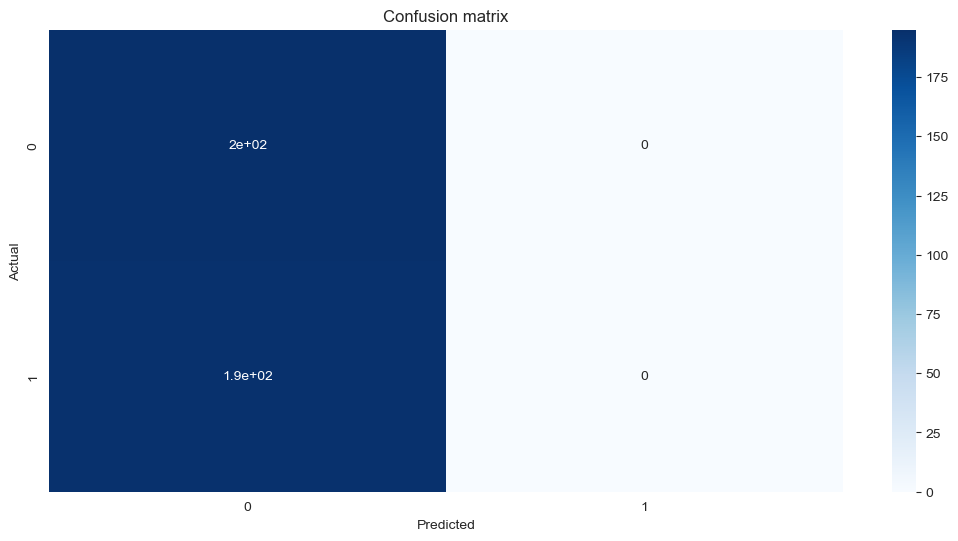

parzen_window_mnbc_fbcsp_with_MIBIF
              precision    recall  f1-score   support

           0     0.5303    0.3590    0.4281       195
           1     0.5136    0.6804    0.5854       194

    accuracy                         0.5193       389
   macro avg     0.5220    0.5197    0.5068       389
weighted avg     0.5220    0.5193    0.5065       389



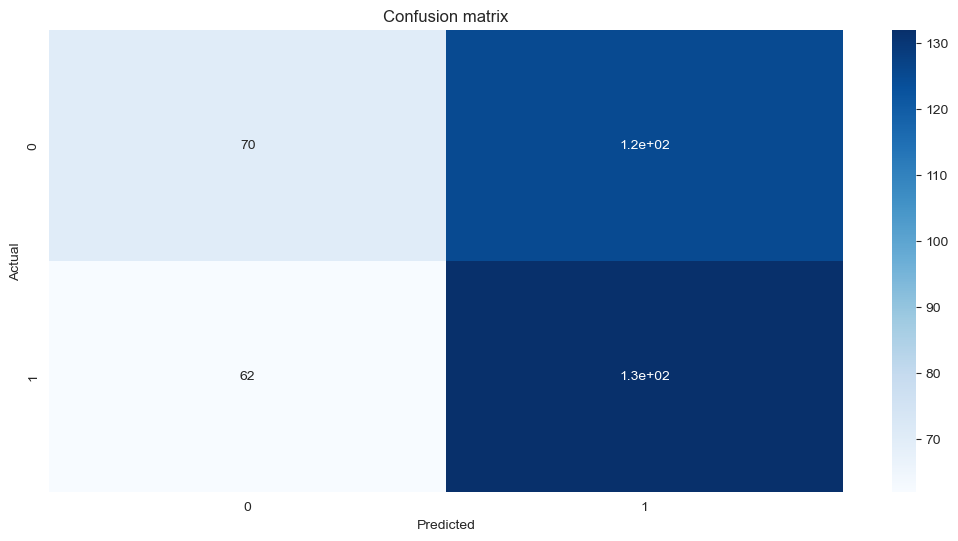

parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF
              precision    recall  f1-score   support

           0     0.5914    0.2821    0.3819       195
           1     0.5270    0.8041    0.6367       194

    accuracy                         0.5424       389
   macro avg     0.5592    0.5431    0.5093       389
weighted avg     0.5593    0.5424    0.5090       389



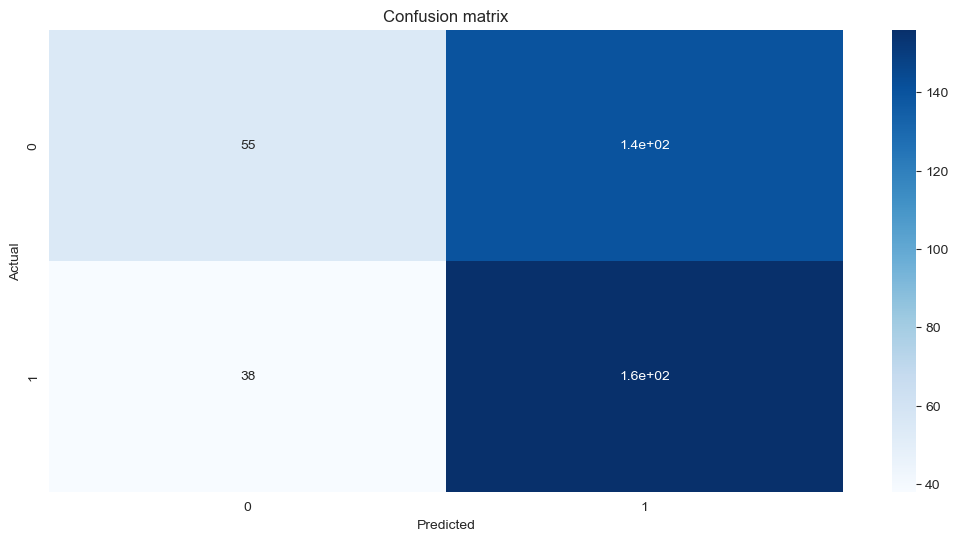

svm_pca12_channel
              precision    recall  f1-score   support

           0     0.5926    0.4103    0.4848       195
           1     0.5472    0.7165    0.6205       194

    accuracy                         0.5630       389
   macro avg     0.5699    0.5634    0.5527       389
weighted avg     0.5700    0.5630    0.5525       389



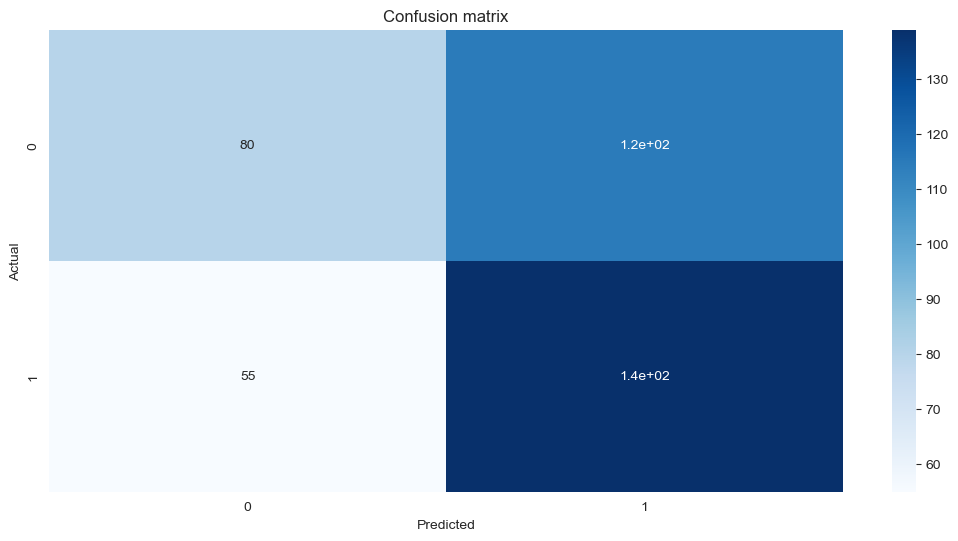

svm_csp4
              precision    recall  f1-score   support

           0     0.6585    0.4154    0.5094       195
           1     0.5714    0.7835    0.6609       194

    accuracy                         0.5990       389
   macro avg     0.6150    0.5994    0.5852       389
weighted avg     0.6151    0.5990    0.5850       389



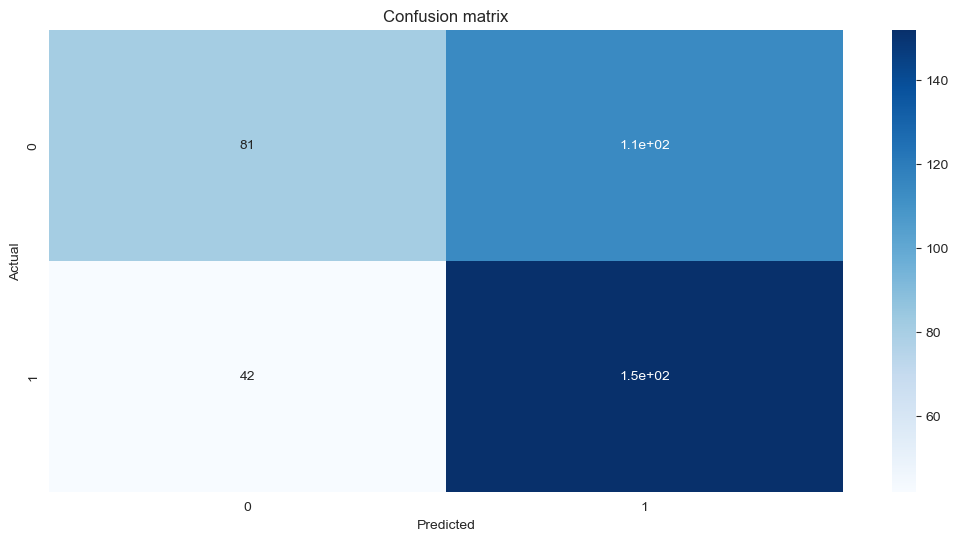

svm_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.7333    0.3949    0.5133       195
           1     0.5845    0.8557    0.6946       194

    accuracy                         0.6247       389
   macro avg     0.6589    0.6253    0.6039       389
weighted avg     0.6591    0.6247    0.6037       389



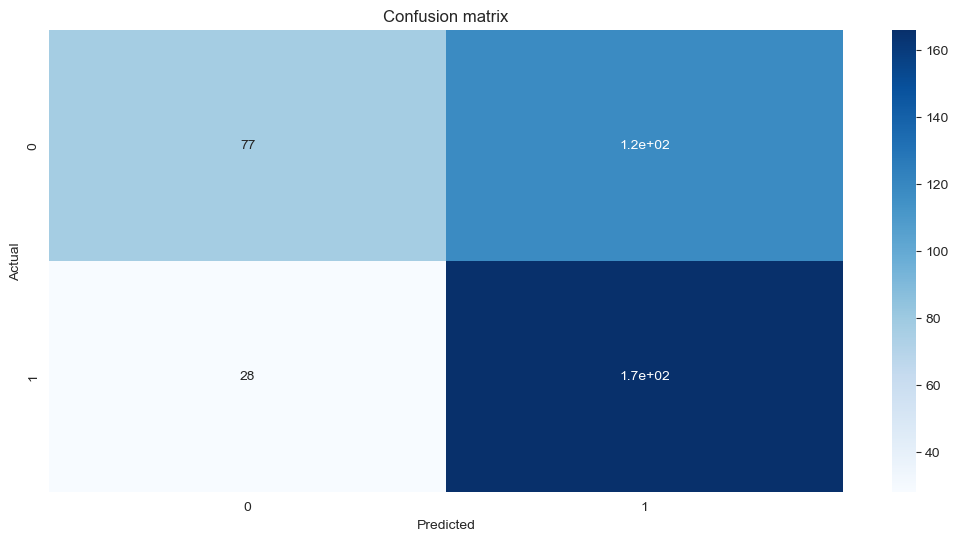

svm_csp15
              precision    recall  f1-score   support

           0     0.7164    0.2462    0.3664       195
           1     0.5435    0.9021    0.6783       194

    accuracy                         0.5733       389
   macro avg     0.6299    0.5741    0.5224       389
weighted avg     0.6302    0.5733    0.5220       389



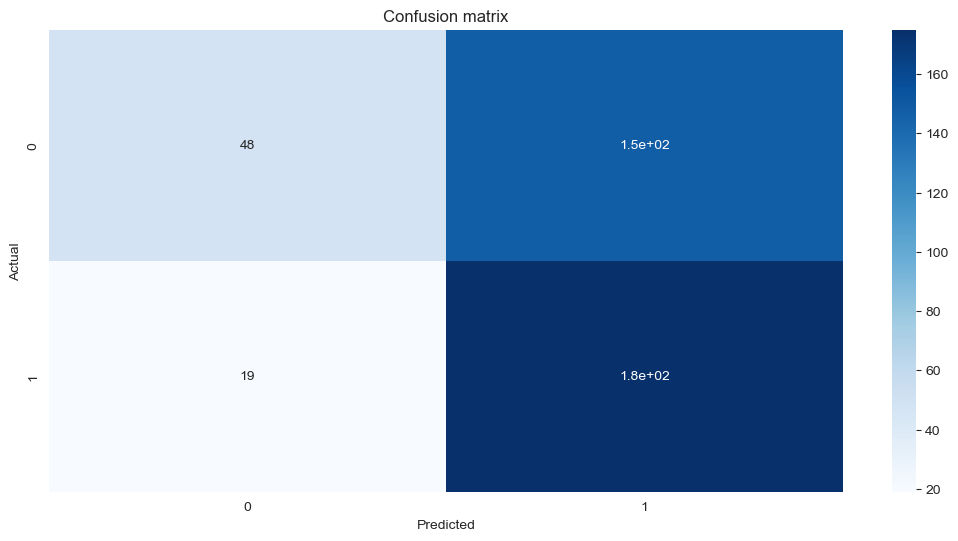

svm_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.6286    0.3385    0.4400       195
           1     0.5458    0.7990    0.6485       194

    accuracy                         0.5681       389
   macro avg     0.5872    0.5687    0.5443       389
weighted avg     0.5873    0.5681    0.5440       389



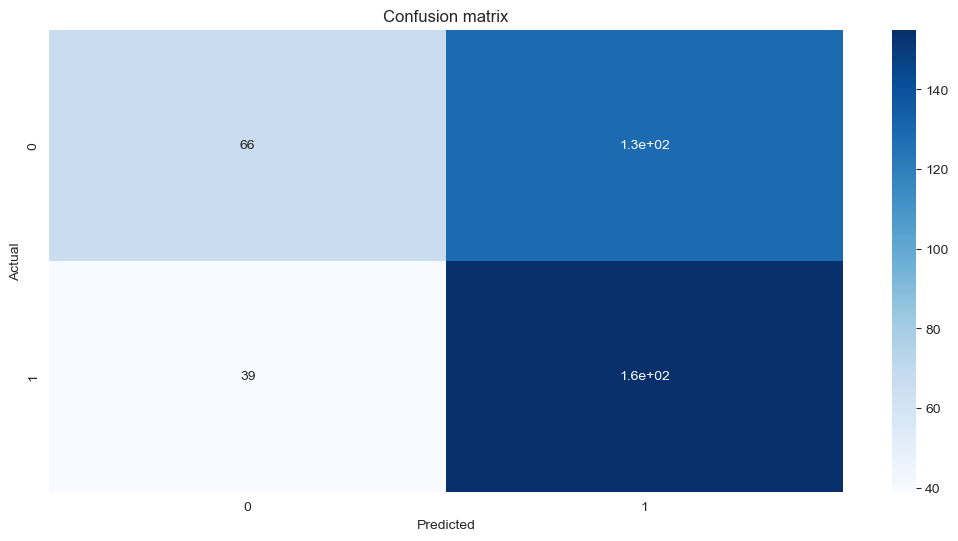

svm_fbcsp
              precision    recall  f1-score   support

           0     0.6180    0.2821    0.3873       195
           1     0.5333    0.8247    0.6478       194

    accuracy                         0.5527       389
   macro avg     0.5757    0.5534    0.5175       389
weighted avg     0.5758    0.5527    0.5172       389



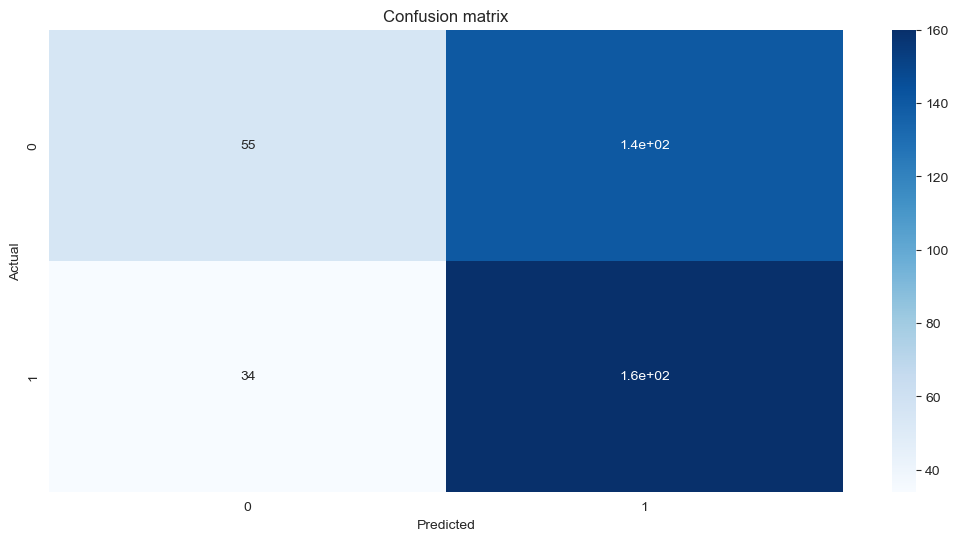

svm_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.6145    0.2615    0.3669       195
           1     0.5294    0.8351    0.6480       194

    accuracy                         0.5476       389
   macro avg     0.5719    0.5483    0.5075       389
weighted avg     0.5720    0.5476    0.5071       389



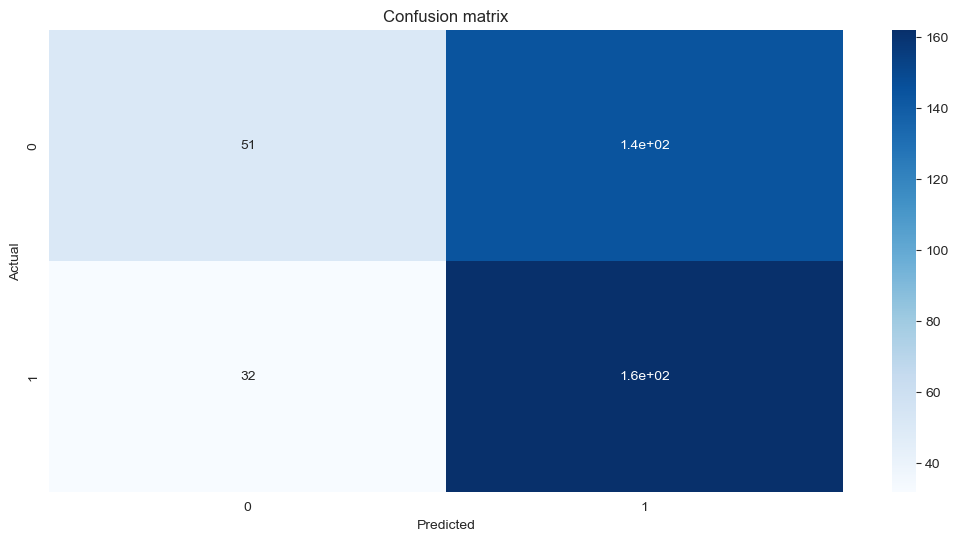

svm_fbcsp_with_MIBIF
              precision    recall  f1-score   support

           0     0.6163    0.2718    0.3772       195
           1     0.5314    0.8299    0.6479       194

    accuracy                         0.5501       389
   macro avg     0.5738    0.5508    0.5126       389
weighted avg     0.5739    0.5501    0.5122       389



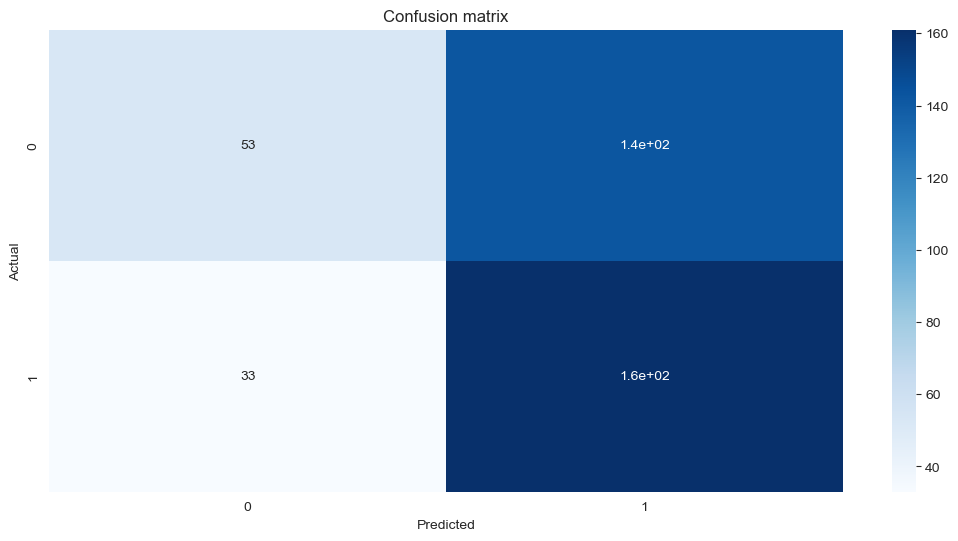

svm_fbcsp_pca12_channel_with_MIBIF
              precision    recall  f1-score   support

           0     0.6364    0.2154    0.3218       195
           1     0.5263    0.8763    0.6576       194

    accuracy                         0.5450       389
   macro avg     0.5813    0.5458    0.4897       389
weighted avg     0.5815    0.5450    0.4893       389



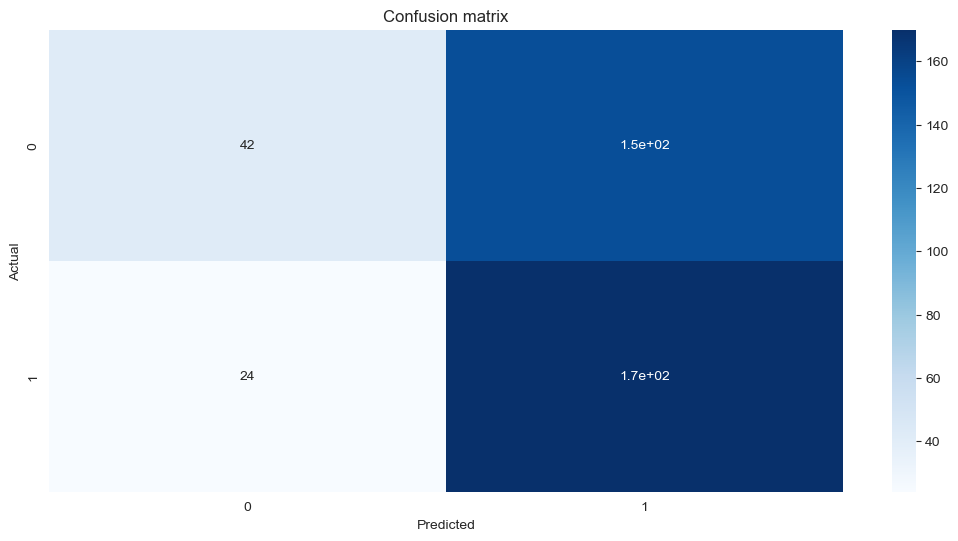

In [56]:
for pipe in Pipes:
    print(pipe.name)
    pipeline = pipe.create_pipeline()
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipeline.predict(pipe.processed_X_val))


In [ ]:
len(y_val)

In [ ]:
np.sum(y_val)

In [ ]:
1347-673

In [ ]:
674/1347


In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [ ]:
pipe.processed_X_val[:, n : (n + w_length)]

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))0
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()